# Use Case: Very Small Radial Grid

Developed by Mike Bardwell. University of Alberta. 2018

In [5]:
# imports
import keras
from keras.models import model_from_json
import numpy as np
import matplotlib.pyplot as plt

import sys; sys.path.append('../'); sys.path.append('../../')
from powerflowsim import PowerFlowSim

In [6]:
# model filename
topology = 'radial'
number_of_houses = 3
number_of_timestamps = 1000
model_name = topology + '_' + str(number_of_houses) + 'houses_' + str(number_of_timestamps) + 'timestamps'

In [7]:
# load dnn model
model_file = model_name + '.json'
model_json = ''
with open(model_file, 'r') as json_file:
    for line in json_file:
        model_json += line
model = model_from_json(model_json)

In [8]:
# re-initialise dnn model with the correct weights
weight_file = model_name + '.h5'
model.load_weights(weight_file, by_name=False)

In [9]:
# prepare load profiles
pfs = PowerFlowSim(number_of_timestamps, topology,  '../_configs/montecarlo' + str(number_of_houses) + '.json')
pfs.nrPfSim()

load_profile = []
for agent in pfs.sim.participants:
    if agent.devices['load'] == None:
        continue
    else:
        load_profile.append(agent.devices['load'].offline_profile['profile'])
load_profile = np.array(load_profile).T

C:\Users\mikey\Anaconda3\envs\microgrid_workcomp\lib\site-packages\pypsa\components.py:758: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  keys=self.passive_branch_components)


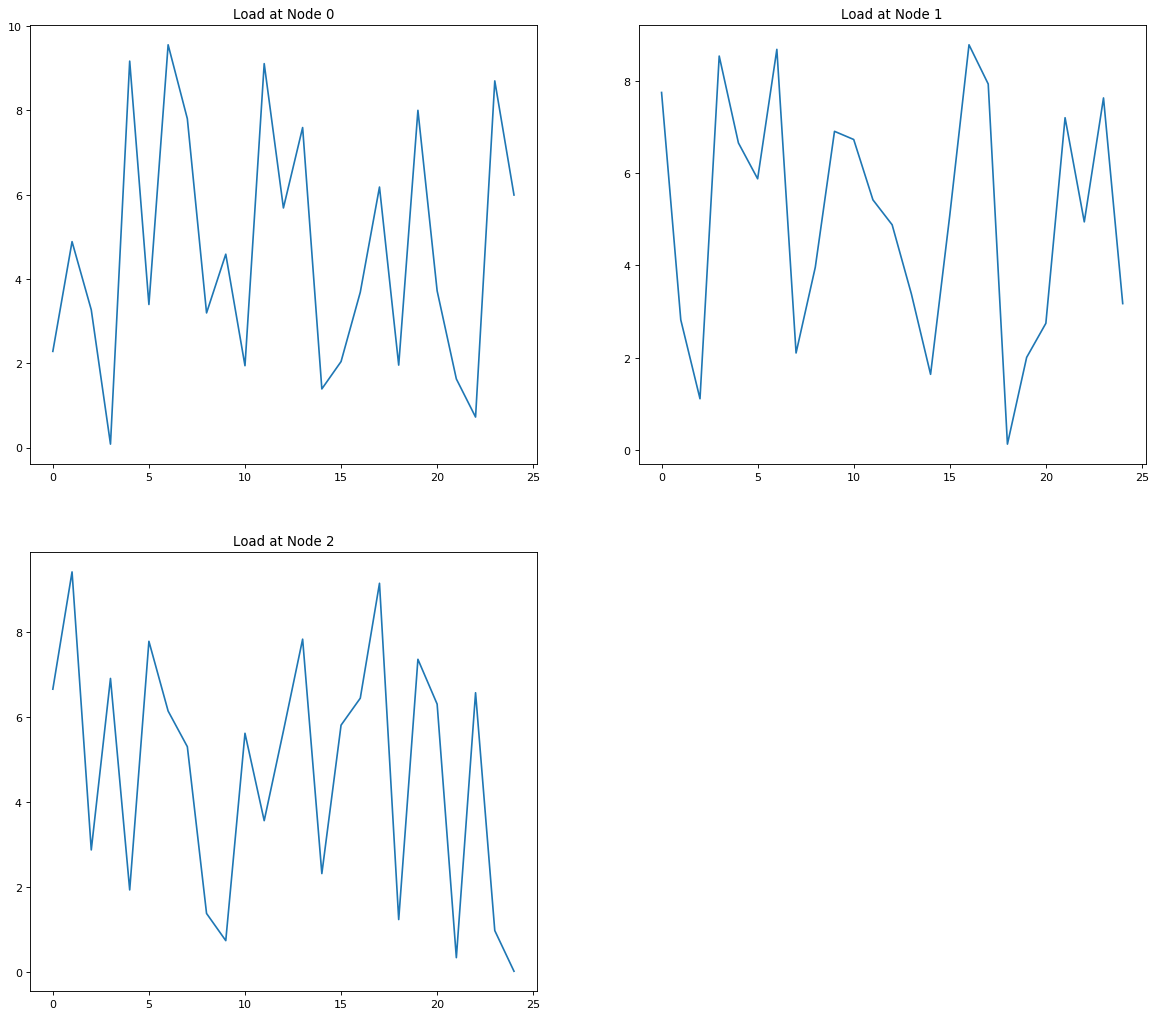

In [11]:
plotting_timestamps = 25
x_axis = [i for i in range(plotting_timestamps)]


# Load profile

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k') # resize subplots for readability
from pylab import *
import math
for i in range(number_of_houses):
    side_length = math.ceil(np.sqrt(number_of_houses))
    subplot(side_length, side_length, i+1)
    title('Load at Node ' + str(i))
    plot(x_axis, load_profile.T[i][0:plotting_timestamps])

In [12]:
def accessPSLFVoltages(node, pfs, number_of_timestamps):
    """
    :type node: int, pfs: PowerFlowSim class
    :rtype np.array of voltage values for node
    """
    name = pfs.network.buses_t['v_mag_pu'].keys()[node]
    return pfs.network.buses_t.v_mag_pu[name][0:number_of_timestamps]

def accessANNVoltages(node, model, load_profile, number_of_timestamps):
    """
    :type node: int, model: Keras model, load_profile: np.array, number_of_timestamps: int
    :rtype np.array of voltage values for node
    """
    predictions = model.predict(load_profile)
    return predictions.T[node][0:number_of_timestamps]

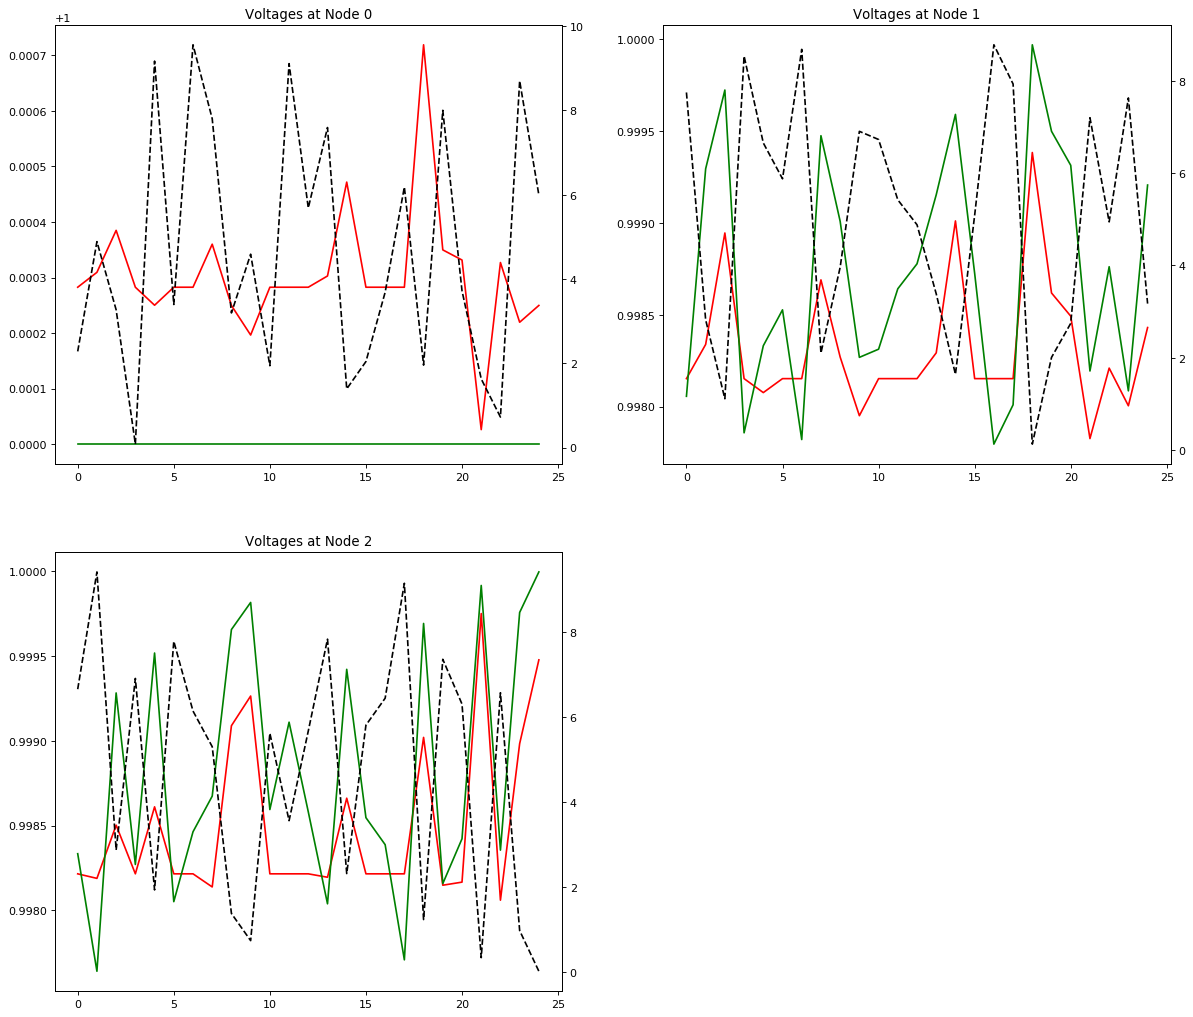

In [13]:
# Voltage Subplots

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k') # resize subplots for readability

for i in range(number_of_houses):
    side_length = math.ceil(np.sqrt(number_of_houses))
    ax1 = subplot(side_length, side_length, i+1)
    ax2 = ax1.twinx()
    title('Voltages at Node ' + str(i))
    ax1.plot(x_axis, accessANNVoltages(i, model, load_profile, plotting_timestamps), 'r',
         x_axis, accessPSLFVoltages(i, pfs, plotting_timestamps), 'g')
    ax2.plot(x_axis, load_profile.T[i][0:plotting_timestamps], '--k')

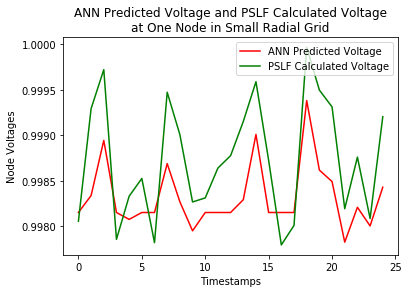

In [16]:
# Voltage plot for saving
plt.plot(x_axis, accessANNVoltages(1, model, load_profile, plotting_timestamps), 'r', 
         x_axis, accessPSLFVoltages(1, pfs, plotting_timestamps), 'g') 
plt.xlabel('Timestamps')
plt.ylabel('Node Voltages')
plt.legend(['ANN Predicted Voltage', 'PSLF Calculated Voltage'])

from textwrap import wrap
title = 'ANN Predicted Voltage and PSLF Calculated Voltage at One Node in Small ' + topology.capitalize() + ' Grid'
plt.title('\n'.join(wrap(title,50)))
plt.savefig('usecase_' + str(number_of_houses) + 'houses_' + topology + 'grid.pdf', transparent = True)

plt.show()